# 03 – Factor-Hedged Strategies (SPY-Hedged Reversal & Momentum)

This notebook mirrors the hedged strategies:

- Use daily excess returns panel from `data_processing`.
- Use `factors` to estimate betas vs a hedge ETF (e.g. SPY) or load precomputed betas.
- Build **hedged** returns: r_hedged = r_stock − beta * r_hedge.
- Run:
  - SPY-hedged daily reversal (same event logic as unhedged).
  - SPY-hedged 12M–1M momentum (rank cross-sectional signal).
- Backtest with `backtest.long_short_backtest`.
- Summarize and visualize performance.

In [5]:
from pathlib import Path

import numpy as np
import pandas as pd

from stat_arb import (
    config,
    data_pipeline,
    factors,
    strategies,
    backtest,
    performance,
    plotting,
)

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

paths_cfg = config.get_paths_config()
hedged_cfg = config.get_strategy_config("factor_hedged")  # or "hedged_reversal"

data_cfg = paths_cfg.get("data", {})
processed_dir = Path(data_cfg.get("processed_dir", "data/processed"))

panel_name = hedged_cfg.get(
    "panel_name",
    data_cfg.get("panel_name", "daily_excess_returns.parquet"),
)
panel_path = processed_dir / panel_name

hedge_ticker = hedged_cfg.get("hedge_ticker", "SPY")
betas_file = hedged_cfg.get("betas_file", "betas_spy.parquet")
betas_path = processed_dir / betas_file

panel_path, hedge_ticker, betas_path

(PosixPath('data/processed/daily_excess_returns.parquet'),
 'SPY',
 PosixPath('data/processed/betas_spy.parquet'))

### Load returns panel & hedge ETF returns

In [7]:
returns = pd.read_parquet(panel_path).sort_index()
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2016-01-04 to 2025-12-09
Columns: 1303 entries, A to ZTS
dtypes: float64(1303)
memory usage: 24.9 MB


In [8]:
hedge_returns = data_pipeline.get_daily_returns(hedge_ticker)
hedge_returns.head()

/Users/aengusmartindonaire/Downloads/stat-arb-strategy/src/stat_arb/data_pipeline.py:200: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tic_clean, start="2015-12-31", end="2026-01-01", progress=False)


Date
2016-01-04   -0.013990
2016-01-05    0.001681
2016-01-06   -0.012624
2016-01-07   -0.024002
2016-01-08   -0.010987
Name: SPY, dtype: float64

### Load or compute betas using factors

In [9]:
if betas_path.exists():
    betas_df = pd.read_parquet(betas_path)
    if "beta" not in betas_df.columns:
        raise KeyError("Expected a 'beta' column in the betas file.")
    betas = betas_df["beta"]
    print(f"Loaded betas from {betas_path}, n={len(betas)}")
else:
    print(f"[WARN] Betas file not found at {betas_path}, computing simple OLS betas vs {hedge_ticker} for all tickers (may be slow).")
    common_idx = returns.index.intersection(hedge_returns.index)
    stock_panel = returns.loc[common_idx]
    hedge_series = hedge_returns.loc[common_idx]

    betas_list = []
    for tic in stock_panel.columns:
        s = stock_panel[tic].dropna()
        joined = pd.concat([s.rename("stock"), hedge_series.rename("hedge")], axis=1).dropna()
        if len(joined) < 50:
            beta_val = np.nan
        else:
            beta_val = factors.calculate_beta_ols(joined["stock"], joined["hedge"])
        betas_list.append((tic, beta_val))

    betas = pd.Series(dict(betas_list), name="beta")
    betas.to_frame().to_parquet(betas_path)
    print("Saved betas to", betas_path)

betas.head()

[WARN] Betas file not found at data/processed/betas_spy.parquet, computing simple OLS betas vs SPY for all tickers (may be slow).
Saved betas to data/processed/betas_spy.parquet


A       1.023366
AA      1.585973
AAL     1.469880
AAP     0.910119
AAPL    1.218265
Name: beta, dtype: float64

### Compute hedge returns

In [10]:
hedged_returns = strategies.compute_hedged_returns(
    stock_returns=returns,
    hedge_returns=hedge_returns,
    betas=betas,
)

hedged_returns.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
A,2499.0,0.000042,0.012853,-0.116109,-0.006048,0.000088,0.005987,0.097363
AA,2499.0,-0.000058,0.029493,-0.145713,-0.016971,-0.001844,0.016213,0.145471
AAL,2499.0,-0.000728,0.028537,-0.177817,-0.013861,-0.001855,0.010838,0.414834
AAP,2499.0,-0.000595,0.025596,-0.345328,-0.010691,-0.000743,0.009529,0.570051
AAPL,2499.0,0.000421,0.012031,-0.070515,-0.005824,0.000216,0.005976,0.095063
ABBV,2499.0,0.000416,0.014804,-0.156435,-0.006449,0.000546,0.007531,0.130427
ABCB,2499.0,-0.000081,0.018938,-0.123309,-0.009839,-0.000552,0.009310,0.139713
ABG,2499.0,0.000120,0.022606,-0.166455,-0.012152,0.000030,0.011725,0.118466
ABNB,1254.0,-0.000541,0.024950,-0.123716,-0.013028,-0.000855,0.011376,0.144653
ABT,2499.0,0.000098,0.012093,-0.096899,-0.005868,0.000005,0.006174,0.078241


### SPY-hedged reversal signal & backtest

In [11]:
threshold = float(hedged_cfg.get("threshold", 0.02))
print(f"Hedged reversal threshold (abs daily hedged return): {threshold:.4f}")

hedged_reversal_signal = strategies.compute_reversal_signal(
    returns=hedged_returns,
    threshold=threshold,
)

hedged_fwd_returns = hedged_returns.shift(-1)
hedged_reversal_signal = hedged_reversal_signal.iloc[:-1]
hedged_fwd_returns = hedged_fwd_returns.iloc[:-1]

cfg = backtest.BacktestConfig(
    top_frac=float(hedged_cfg.get("top_frac", 0.1)),
    bottom_frac=float(hedged_cfg.get("bottom_frac", 0.1)),
    cost_bps=float(hedged_cfg.get("cost_bps", 0.0)),
    min_names=int(hedged_cfg.get("min_names", 10)),
)

cfg

Hedged reversal threshold (abs daily hedged return): 0.0200


BacktestConfig(top_frac=0.1, bottom_frac=0.1, cost_bps=5.0, min_names=10)

In [12]:
%%time

spy_hedged_reversal_ret, spy_hedged_reversal_w = backtest.long_short_backtest(
    fwd_returns=hedged_fwd_returns,
    signal=hedged_reversal_signal,
    cfg=cfg,
)

spy_hedged_reversal_ret.describe()

CPU times: user 2.62 s, sys: 117 ms, total: 2.74 s
Wall time: 2.81 s


count    2236.000000
mean       -0.001356
std         0.024333
min        -0.265719
25%        -0.013672
50%        -0.001501
75%         0.010498
max         0.165199
Name: portfolio_ret, dtype: float64

### SPY-hedged 12M-1M momentum signal and backtest

In [13]:
# Build 12M-1M momentum rank on **hedged** returns
hedged_mom_rank = strategies.compute_12m_1m_momentum_rank(
    returns=hedged_returns,
    lookback_days=252,
    gap_days=21,
)

# Forward hedged returns for momentum trades
hedged_mom_fwd = hedged_returns.shift(-1)
hedged_mom_rank = hedged_mom_rank.iloc[:-1]
hedged_mom_fwd = hedged_mom_fwd.iloc[:-1]

hedged_mom_rank.describe().T.head(10)


,count,mean,std,min,25%,50%,75%,max
A,2247.0,0.000296,0.208737,-0.439264,-0.175129,0.019852,0.179665,0.406977
AA,2247.0,-0.042384,0.388357,-0.496219,-0.451033,-0.110970,0.360157,0.495602
AAL,2247.0,-0.212114,0.250122,-0.495421,-0.426919,-0.292683,-0.045103,0.442043
AAP,2247.0,-0.143414,0.321943,-0.497429,-0.439061,-0.219965,0.070369,0.484747
AAPL,2247.0,0.106882,0.231422,-0.408602,-0.081873,0.110300,0.310236,0.483287
ABBV,2247.0,0.102851,0.237640,-0.463981,-0.060748,0.096965,0.315505,0.485521
ABCB,2247.0,-0.025448,0.281822,-0.487759,-0.293046,-0.003916,0.236018,0.450673
ABG,2247.0,0.049609,0.247968,-0.438175,-0.165082,0.064929,0.269462,0.482803
ABNB,1002.0,-0.125153,0.234385,-0.447090,-0.325162,-0.192674,0.047082,0.414530
ABT,2247.0,0.052179,0.215154,-0.408911,-0.142192,0.057621,0.255805,0.418463


In [14]:
%%time

spy_hedged_mom_ret, spy_hedged_mom_w = backtest.long_short_backtest(
    fwd_returns=hedged_mom_fwd,
    signal=hedged_mom_rank,
    cfg=cfg,
)

spy_hedged_mom_ret.describe()

CPU times: user 4.12 s, sys: 218 ms, total: 4.33 s
Wall time: 4.45 s


count    2247.000000
mean        0.001588
std         0.052327
min        -0.233033
25%        -0.007389
50%         0.001748
75%         0.009712
max         2.351256
Name: portfolio_ret, dtype: float64

### Performance summary and plots

In [15]:
ic_hedged_rev = performance.rank_ic_by_date(
    signal=hedged_reversal_signal,
    fwd_returns=hedged_fwd_returns,
)
ic_hedged_mom = performance.rank_ic_by_date(
    signal=hedged_mom_rank,
    fwd_returns=hedged_mom_fwd,
)

summary_hedged_rev = performance.summarize_portfolio_performance(
    portfolio_returns=spy_hedged_reversal_ret,
    ic_series=ic_hedged_rev,
    periods_per_year=252,
)
summary_hedged_mom = performance.summarize_portfolio_performance(
    portfolio_returns=spy_hedged_mom_ret,
    ic_series=ic_hedged_mom,
    periods_per_year=252,
)

performance.build_summary_table(
    {
        "SPY-Hedged Reversal": summary_hedged_rev,
        "SPY-Hedged 12M-1M Momentum": summary_hedged_mom,
    }
)

,Mean IC,IC Hit Rate,Cumulative Return,Sharpe,Max Drawdown
Strategy,,,,,
SPY-Hedged Reversal,0.012863,0.531625,-0.975342,-0.884403,-0.995067
SPY-Hedged 12M-1M Momentum,0.016799,0.566533,7.218043,0.481771,-0.390824


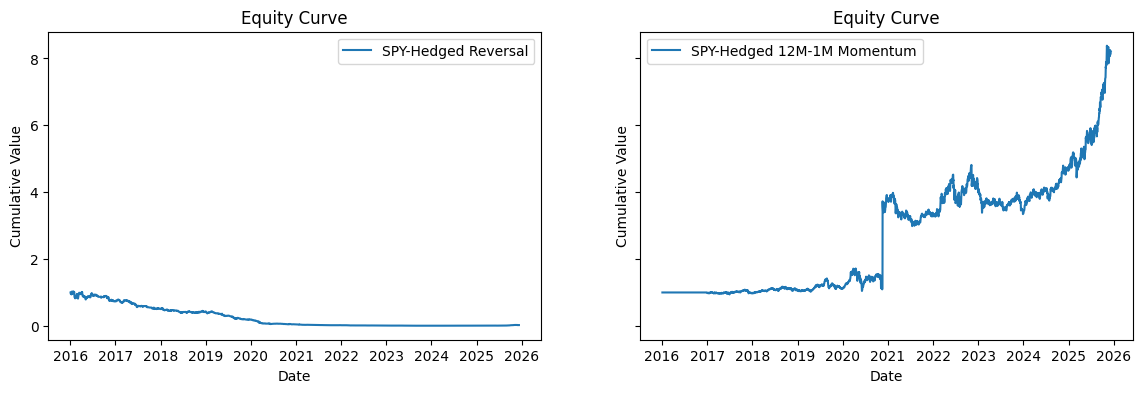

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
plotting.plot_equity_curve(spy_hedged_reversal_ret, ax=ax[0], label="SPY-Hedged Reversal")
plotting.plot_equity_curve(spy_hedged_mom_ret, ax=ax[1], label="SPY-Hedged 12M-1M Momentum")
plt.show()

In [ ]:
## EOF

### Save .par files for 04 use

In [17]:
from pathlib import Path
import pandas as pd
from stat_arb import config

paths_cfg = config.get_paths_config()
data_cfg = paths_cfg.get("data", {})
processed_dir = Path(data_cfg.get("processed_dir", "data/processed"))

# === SPY-hedged reversal ===
out_dir_rev = processed_dir / "spy_hedged_reversal"
out_dir_rev.mkdir(parents=True, exist_ok=True)

print("Saving SPY-hedged reversal outputs to:", out_dir_rev)

pd.DataFrame({"portfolio_ret": spy_hedged_reversal_ret}).to_parquet(
    out_dir_rev / "portfolio_returns.parquet"
)
ic_hedged_rev.to_frame("rank_ic").to_parquet(out_dir_rev / "rank_ic.parquet")
spy_hedged_reversal_w.to_parquet(out_dir_rev / "weights.parquet")

Saving SPY-hedged reversal outputs to: data/processed/spy_hedged_reversal


In [18]:
# === SPY-hedged 12M–1M momentum ===
out_dir_mom = processed_dir / "spy_hedged_momentum"
out_dir_mom.mkdir(parents=True, exist_ok=True)

print("Saving SPY-hedged momentum outputs to:", out_dir_mom)

pd.DataFrame({"portfolio_ret": spy_hedged_mom_ret}).to_parquet(
    out_dir_mom / "portfolio_returns.parquet"
)
ic_hedged_mom.to_frame("rank_ic").to_parquet(out_dir_mom / "rank_ic.parquet")
spy_hedged_mom_w.to_parquet(out_dir_mom / "weights.parquet")

Saving SPY-hedged momentum outputs to: data/processed/spy_hedged_momentum


In [ ]:
## EOF